In [0]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [0]:
# Read Data
data = pd.read_csv(r'UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [0]:
data.shape

(8732, 8)

In [0]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

In [0]:
# Example of a Siren spectrogram
y, sr = librosa.load(r'UrbanSound8K\UrbanSound8K\audio\fold6\135160-8-0-0.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

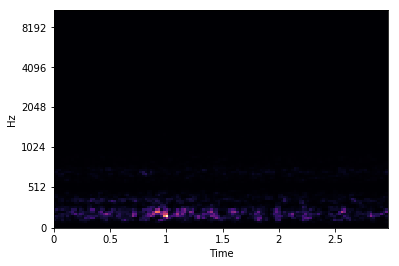

In [0]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')


In [0]:

# Example of a AC spectrogram
y, sr = librosa.load(r'UrbanSound8K\UrbanSound8K\audio\fold1\134717-0-0-19.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

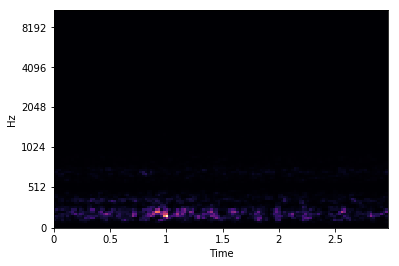

In [0]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [0]:
# Example of a children playing spectrogram
y, sr = librosa.load(r'UrbanSound8K\UrbanSound8K\audio\fold9\13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

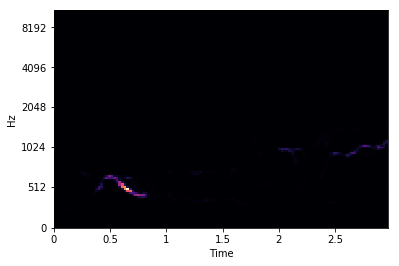

In [0]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [0]:
# Example of a drilling spectrogram
y, sr = librosa.load(r'UrbanSound8K\UrbanSound8K\audio\fold9\137815-4-0-0.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

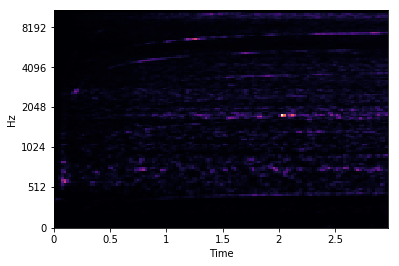

In [0]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [0]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [0]:
D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load('UrbanSound8K/UrbanSound8K/audio/' + row.path, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    D.append( (ps, row.classID) )

In [0]:
print("Number of samples: ", len(D))

Number of samples:  7467


In [0]:
dataset = D
random.shuffle(dataset)

train = dataset[:7000]
test = dataset[7000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [0]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.2))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 467 samples
Epoch 1/12
7000/7000 [==============================] - 81s 12ms/step - loss: 1.1297 - acc: 0.6143 - val_loss: 1.2146 - val_acc: 0.5824
Epoch 2/12
7000/7000 [==============================] - 77s 11ms/step - loss: 1.0271 - acc: 0.6551 - val_loss: 1.0675 - val_acc: 0.6467
Epoch 3/12
7000/7000 [==============================] - 77s 11ms/step - loss: 0.9024 - acc: 0.6919 - val_loss: 1.0574 - val_acc: 0.6424
Epoch 4/12
7000/7000 [==============================] - 76s 11ms/step - loss: 0.8556 - acc: 0.7136 - val_loss: 1.0160 - val_acc: 0.6852
Epoch 5/12
7000/7000 [==============================] - 74s 11ms/step - loss: 0.8955 - acc: 0.7204 - val_loss: 1.0368 - val_acc: 0.6745
Epoch 6/12
7000/7000 [==============================] - 76s 11ms/step - loss: 0.8185 - acc: 0.7320 - val_loss: 1.0649 - val_acc: 0.6938
Epoch 7/12
7000/7000 [==============================] - 74s 11ms/step - loss: 0.7124 - acc: 0.7633 - val_loss: 1.0177 - val_acc: 0.6874
E

In [0]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

Training Accuracy:  0.857571428503309


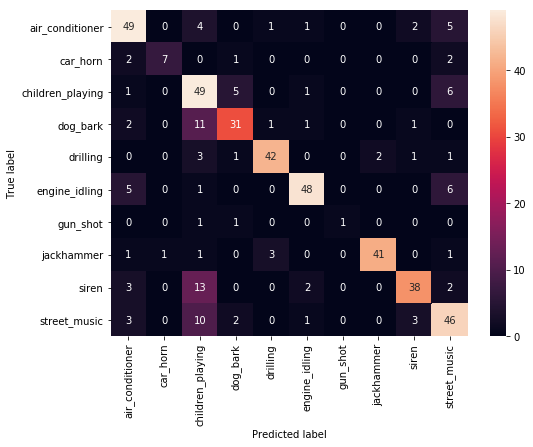

In [0]:
import seaborn as sns
y_pred = model.predict(X_test)
cm =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,
                     index = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music'], 
                     columns = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##  Implementation of Data Augmentation Techniques 


### 1.Time Stretching (TS)

In [0]:
y, sr = librosa.load('UrbanSound8K/UrbanSound8K/audio/fold1/14113-4-0-1.wav', duration=2.97)
y_changed = librosa.effects.time_stretch(y, rate=0.81)
librosa.output.write_wav('UrbanSound8K\\UrbanSound8K\\augmented\\fold1\\speed_81\\14113-4-0-1.wav' ,y_changed, sr)

In [0]:
rate = 0.81 # replace with 1.07 and execute again

for row in valid_data.itertuples():
    y, sr = librosa.load('UrbanSound8K/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.time_stretch(y, rate=rate)
    librosa.output.write_wav('UrbanSound8K/UrbanSound8K/augmented/fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/' + row.slice_file_name ,y_changed, sr)

### 2. Pitch Shifting (PS1)

In [0]:
n_steps = 2 #-1, -2, 2, 1

for row in valid_data.itertuples():
    y, sr = librosa.load('UrbanSound8K/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('UrbanSound8K/UrbanSound8K/augmented/fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/' + row.slice_file_name ,y_changed, sr)

### 3. Pitch Shifting (PS2)

In [0]:
n_steps = 2.5 #-2.5, -3.5, 2.5, 3.5

for row in valid_data.itertuples():
    y, sr = librosa.load('UrbanSound8K/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('UrbanSound8K/UrbanSound8K/augmented/fold' + str(row.fold) + '/ps2_' + str(int(n_steps*10)) + '/' + row.slice_file_name ,y_changed, sr)

In [0]:
len(D)

The dataset consists of:

(a) 1-7467 normal samples.
(b) 7468-14934 samples Pitch modulated 2.5 semitones higher.
(c) 14935-22401 samples Pitch modeulated 2 semitones higher.
(d) 22402-29869 samples Slowed down to 0.81.
(e) 29869-37310 samples speed up by 1.07

Follow the same procedure using this dataset as we did earliar.

In [0]:
dataset = D
random.shuffle(dataset)

train = dataset[:35000]
test = dataset[35000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [0]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

In [0]:
import seaborn as sns
y_pred = model.predict(X_test)
cm =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,
                     index = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music'], 
                     columns = ['air_conditioner','car_horn','children_playing','dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()